## Цели и задачи проекта
Цель данного проекта - разобраться, как ведут себя пользователи  мобильного приложения для продажи продуктов питания и повлияет ли изменение шрифта на их поведение. 

В процессе мы изучим воронку продаж, узнайте, как и сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах и на каких именно.

После этого исследуем результаты A/A/B-эксперимента. Проверим, как влияет изменение шрифтов на поведение пользователей и какой шрифт лучше. Для повыщения уверенности пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми, таким образом если две контрольные группы окажутся равны, мы можем быть уверены в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также помогает понять, сколько времени и данных потребуется для дальнейших тестов.

In [1]:
import pandas as pd
import datetime as dt
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import math as mth
import warnings

## Шаг 1. Откроем файл с данными и изучим общую информацию

На этом этапе мы ознакомимся с данными, их количеством и форматом

In [2]:
data = pd.read_csv('/datasets/logs_exp.csv', sep='\t', parse_dates=['EventTimestamp'])

In [3]:
data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  object
 3   ExpId           244126 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 7.5+ MB


### Вывод
В таблице четыре столбца и 244126 строк. Названия столбцов не в удобном формате, а столбец с датой не в формате дат. Исправим это в следующем шаге

## Шаг 2. Подготовим данные
Теперь перейдем к предобработке данных: изменим название столбцов, преведем данные с датами в более удобный и понятный формат, а также проверим данные на наличие пропусков и дубликатов

### Заменим названия столбцов на удобные 


In [5]:
data.columns = ['event_name', 'user_id', 'time_stamp', 'group']

### Проверим дубликаты, пропуски и типы данных. 


In [6]:
print(data.duplicated().sum())

413


In [7]:
data = data.drop_duplicates()

In [8]:
print(data.isna().sum())

event_name    0
user_id       0
time_stamp    0
group         0
dtype: int64


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   event_name  243713 non-null  object
 1   user_id     243713 non-null  int64 
 2   time_stamp  243713 non-null  object
 3   group       243713 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 9.3+ MB


### Добавим столбец даты и времени, а также отдельный столбец дат

In [10]:
data['event_time'] = pd.to_datetime(data['time_stamp'], unit='s', errors='coerce')

In [11]:
print(data[data['time_stamp'].isna()])

Empty DataFrame
Columns: [event_name, user_id, time_stamp, group, event_time]
Index: []


In [12]:
data['event_date'] = data['event_time'].dt.date

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  243713 non-null  object        
 1   user_id     243713 non-null  int64         
 2   time_stamp  243713 non-null  object        
 3   group       243713 non-null  int64         
 4   event_time  243713 non-null  datetime64[ns]
 5   event_date  243713 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 13.0+ MB


### Вывод
В процессе обработки данных были заменены названия столбцов, были обнаружены 413 дубликатов, которые были удалены, пропусков не было обнаружено. Также, на основе данных по времени события, были добавлены столбцы с датой и временем каждого события.

## Шаг 3. Изучим и проверим данные
Перейдем непосредственно к изучению самих данных. Посмотрим на количество всех событий и пользователей, а также на среднее количество событий на каждого пользователя. Также оценим качество данных и срок, за который у нас эти данные есть.

### Посмотрим на данные поближе
Для начала посмотрим, сколько всего событий в логе, сколько всего пользователей и колько в среднем событий приходится на пользователя

In [14]:
print(f"Всего в логе {data['event_name'].count()} событий")
print(f"Всего в логе {data['user_id'].nunique()} пользователей")
print(f"Событий на каждого пользователя в среднем {data.groupby('user_id')['event_name'].count().mean()} ")
print(data.groupby('user_id')['event_name'].count().median())
print(data.groupby('user_id')['event_name'].count().min())
print(data.groupby('user_id')['event_name'].count().max())


Всего в логе 243713 событий
Всего в логе 7551 пользователей
Событий на каждого пользователя в среднем 32.27559263673685 
20.0
1
2307


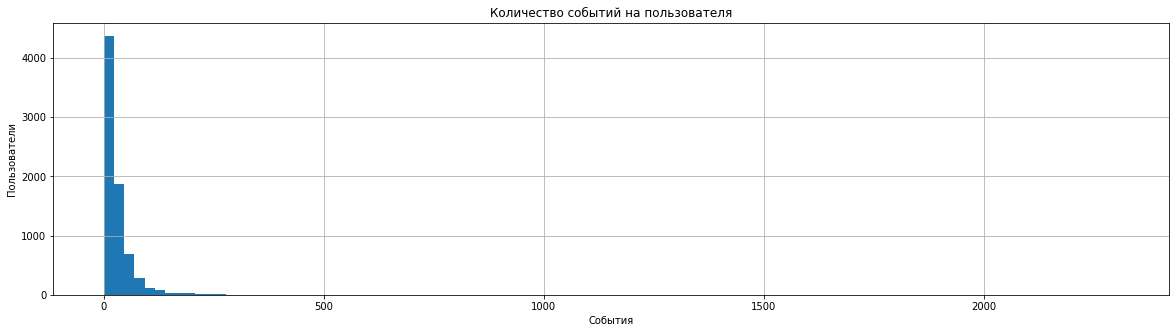

In [15]:
plt.figure(figsize=(20, 5))
data.groupby('user_id')['event_name'].count().hist(bins=100)
plt.xlabel('События') 
plt.ylabel('Пользователи')
plt.title('Количество событий на пользователя');

### Теперь посмотрим, за какой период у нас есть данные. Найдем максимальную и минимальную дату. 

In [16]:
print(data['event_date'].min())
print(data['event_date'].max())

2019-07-25
2019-08-07


У нас всего есть данные за период с 23/07/2019 по 07/08/2019

### Посмотрим, насколько полные данные за весь период

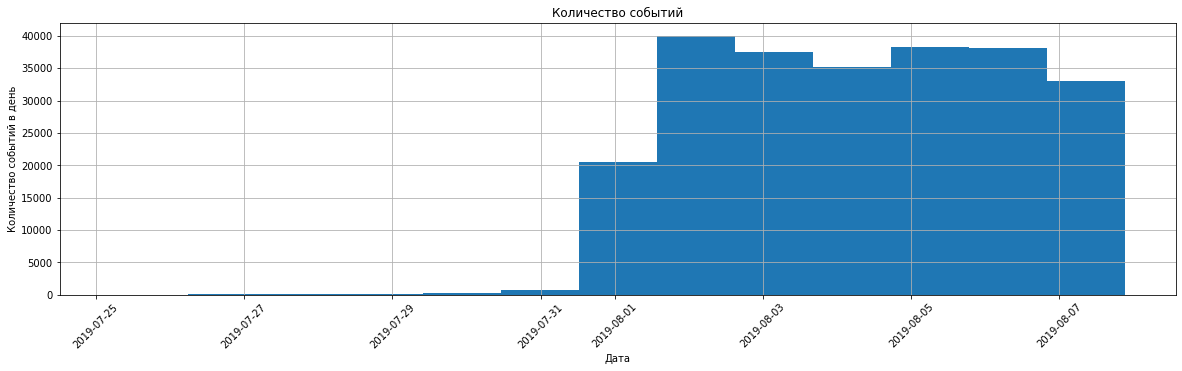

In [17]:
plt.figure(figsize=(20, 5))
data['event_time'].hist(bins=13)
plt.ylabel('Количество событий в день')
plt.xlabel('Дата')
plt.title('Количество событий')
plt.xticks(rotation='45');

Данных до 31.07.2019 очень мало, и они могут засорять общую картину, поэтому их лучше отбросить. Но для начала посмотрим, какой процент от общего объема они составляют.

In [18]:
print((data.query('event_time <= datetime(2019, 7, 31)')['event_name'].count())/data['event_name'].count())

0.00326613680845913


Данных до 31.07.2019 меньше одного процента, поэтому можем их отбросить

In [19]:
data_filt = data.query('event_time >= datetime(2019, 7, 30)')

In [20]:
total = pd.pivot_table(
    data_filt,
    values='user_id',
    index='group',
    aggfunc='nunique'
).reset_index()
total.columns = (['group', 'total'])
display(total)

,group,total
0,246,2487
1,247,2520
2,248,2540


### Проверим, есть ли пользователи, которые попали в две или три группы сразу

In [21]:
print(data_filt.groupby('user_id').agg({'group' : 'nunique'}).query('group>1').count())
double_users = data_filt.groupby('user_id').agg({'group' : 'nunique'}).reset_index().query('group>1')['user_id'].unique()


group    0
dtype: int64


In [22]:
print(len(double_users))

0


### Вывод
У нас всего есть данные за период с 23/07/2019 по 07/08/2019. Данных до 31.07.2019 очень мало, и они могут засорять общую картину и их меньше одного процента, поэтому мы их отбросили

## Шаг 4. Изучим воронку событий
Посмотрим, какие события есть в логах и как часто они встречаются. Посчитаем, сколько пользователей совершали каждое из этих событий. Посчитаем долю пользователей, которые хоть раз совершали событие.
Проверим, в каком порядке происходят события. Посмотрим на воронку событий и посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). Узнаем, на каком шаге теряем больше всего пользователей и 
какая доля пользователей доходит от первого события до оплаты.

### Посмотрим, какие события есть в логах, как часто они встречаются. Отсортируем события по частоте.

In [82]:
events = data_filt.groupby('event_name').agg({'user_id':'count'})
display(events.sort_values('user_id', ascending=False))

,user_id
event_name,
MainScreenAppear,118857
OffersScreenAppear,46758
CartScreenAppear,42609
PaymentScreenSuccessful,34091
Tutorial,1014


Самое частое событие - MainScreenAppear, оно было совершено 118857 раз

### Посчитаем, сколько пользователей совершали каждое из этих событий. Также отсортируем события по числу пользователей. Посчитаем долю пользователей, которые хоть раз совершали событие.

In [83]:
events_g = data_filt.groupby('event_name').agg({'user_id':'nunique'}).reset_index().reindex(columns=['event_name', 'user_id']).sort_values('user_id', ascending=False)

events_g['share'] = round((events_g['user_id']/data_filt['user_id'].nunique()*100),2)

display(events_g)

,event_name,user_id,share
1,MainScreenAppear,7435,98.52
2,OffersScreenAppear,4612,61.11
0,CartScreenAppear,3747,49.65
3,PaymentScreenSuccessful,3546,46.99
4,Tutorial,845,11.20


### Вывод
Всего 7435 пользователей совершили как минимум одно событие, это 98,52% от общего количества пользователей. 
Логично предположить, что события происходят в следующем порядке: MainScreenAppear -> OffersScreenAppear -> CartScreenAppear -> PaymentScreenSuccessful, в то время, как Tutorial опциональное действие и не все польователи его проходят. Для наших целей учитывать его не имеет смысла, поэтому далее не будем его учитывать.

У первого события `MainScreenAppear` доля пользователей, его совершивших, составляет 98.5%, скорее всего это связано с тем, что некоторые пользователи, зарегистрированные ранее, не совершали никаких действий в выбранный период

Видим, что 46,99% пользователей доходят от первого действия до покупки. Больше всего пользователей мы теряем при переходе с MainScreenAppear на OffersScreenAppear, это примерно 37% от общего количества пользователей.

## Шаг 5. Изучим результаты эксперимента

Теперь перейдем непосредтвенно к нашему эксперименту и рассмотрим поведение пользователей в разрезе групп. Для этого рассмотрим, сколько пользователей в каждой группе и какие события они совершают. 
Также, поскольку мы проводили А/А/В тест для определения поведения пользователей в разных группах, проведем статистический анализ А/А и А/В групп, а затем объеденим А/А группы в одну и сравним ее с В группой с измененным шрифтом.


### Посмотрим на общее количество пользователей в каждой группе

In [84]:
total = pd.pivot_table(
    data_filt,
    values='user_id',
    index='group',
    aggfunc='nunique'
).reset_index()
total.columns = (['group', 'total'])
display(total)

,group,total
0,246,2487
1,247,2520
2,248,2540


Проверим, находят ли статистические критерии разницу между контрольными группами 246 и 247, чтобы проверить корректность всех механизмов и расчётов. 

###  Посчитаем число пользователей, совершивших каждое событие в каждой из контрольных групп. 

In [85]:
aab_table = pd.pivot_table(
    data_filt, values='user_id', index='group', columns='event_name', aggfunc='nunique'
).reset_index()
aab_table = aab_table[['group', 'MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']]
aab_table

event_name,group,MainScreenAppear,OffersScreenAppear,CartScreenAppear,PaymentScreenSuccessful
0,246,2454,1545,1269,1202
1,247,2482,1529,1240,1160
2,248,2499,1538,1238,1184


### Посчитаем долю пользователей, совершивших эти события. Для этого нам надо добавить общее количество пользователец в каждой группе

In [86]:
aab_table = aab_table.merge(total, left_on='group', right_on='group')
display(aab_table)

,group,MainScreenAppear,OffersScreenAppear,CartScreenAppear,PaymentScreenSuccessful,total
0,246,2454,1545,1269,1202,2487
1,247,2482,1529,1240,1160,2520
2,248,2499,1538,1238,1184,2540


In [87]:
col = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']

aab_share = pd.DataFrame({'group':[246, 247, 248]})
for i in col:
    aab_share[i+', share'] = aab_table[i]/aab_table['total']
aab_share

,group,"MainScreenAppear, share","OffersScreenAppear, share","CartScreenAppear, share","PaymentScreenSuccessful, share"
0,246,0.986731,0.621230,0.510253,0.483313
1,247,0.984921,0.606746,0.492063,0.460317
2,248,0.983858,0.605512,0.487402,0.466142


### Сравним две контрольные группы
Проверим, будет ли отличие между группами статистически достоверным для всех событий (для этого обернем проверку в отдельную функцию). Можно ли сказать, что разбиение на группы работает корректно?

In [88]:
def z_calc(p1, p2, total_a, total_b, alpha=0.05):
    
    p_combined = (p1*total_a+p2*total_b)/(total_a+total_b)
       
    z_value = (p1-p2)/mth.sqrt(p_combined*(1-p_combined)*(1/total_a+1/total_b))
    print(f'z-value - {round(z_value,4)}')
    
    distr = st.norm(0, 1)
    
    p_value = (1-distr.cdf(abs(z_value))) * 2
    print(f'p-значение: {round(p_value,4)}')
    
    if p_value < alpha: 
        print('Отвергаем нулевую гипотезу: меджу долями есть значимая разница')
    else: 
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований полагать, что доли разные')

        
        

In [89]:
total_246 = total.iloc[0,1]
total_247 = total.iloc[1,1]
total_248 = total.iloc[2,1]

Применим z-тест  проверим гипотезу о равенстве долей:

Н0 - В группах доли пользователей на каждом шаге равны

Н1 - Доли на данном шаге различны

alpha = 0,05

In [90]:
for i in range(1,5):
    print('Событие:')
    print(aab_share.columns[i])
    print()
    z_calc(aab_share.iloc[0,i], aab_share.iloc[1,i], total_246, total_247)
    print('\n-------------\n')

Событие:
MainScreenAppear, share

z-value - 0.5417
p-значение: 0.588
Не получилось отвергнуть нулевую гипотезу, нет оснований полагать, что доли разные

-------------

Событие:
OffersScreenAppear, share

z-value - 1.0526
p-значение: 0.2925
Не получилось отвергнуть нулевую гипотезу, нет оснований полагать, что доли разные

-------------

Событие:
CartScreenAppear, share

z-value - 1.2871
p-значение: 0.1981
Не получилось отвергнуть нулевую гипотезу, нет оснований полагать, что доли разные

-------------

Событие:
PaymentScreenSuccessful, share

z-value - 1.6298
p-значение: 0.1032
Не получилось отвергнуть нулевую гипотезу, нет оснований полагать, что доли разные

-------------



Таким образом, мы доказали, что доли групп 246 и 247 (А/А тест) равны, а значит, пользователей корректно разделили на группы и теперь можем перейти к сравнению долей групп 247 и 248 (А/В тест)

    

### Сравним первую контрольную группу с тестовой

In [91]:
for i in range(1,5):
    print('Событие:')
    print(aab_share.columns[i])
    print()
    z_calc(aab_share.iloc[1,i], aab_share.iloc[2,i], total_247, total_248)
    print('-------------')
    print()

Событие:
MainScreenAppear, share

z-value - 0.3048
p-значение: 0.7605
Не получилось отвергнуть нулевую гипотезу, нет оснований полагать, что доли разные
-------------

Событие:
OffersScreenAppear, share

z-value - 0.0898
p-значение: 0.9284
Не получилось отвергнуть нулевую гипотезу, нет оснований полагать, что доли разные
-------------

Событие:
CartScreenAppear, share

z-value - 0.3317
p-значение: 0.7401
Не получилось отвергнуть нулевую гипотезу, нет оснований полагать, что доли разные
-------------

Событие:
PaymentScreenSuccessful, share

z-value - -0.4154
p-значение: 0.6778
Не получилось отвергнуть нулевую гипотезу, нет оснований полагать, что доли разные
-------------



### Сравним вторую контрольную группу с тестовой
А/В тест также не обнаруджил статистических различий между группами 247 и 248, перейдем к группам 246 и 248

In [92]:
for i in range(1,5):
    print('Событие:')
    print(aab_share.columns[i])
    print()
    z_calc(aab_share.iloc[0,i], aab_share.iloc[2,i], total_246, total_248)
    print('-------------')
    print()

Событие:
MainScreenAppear, share

z-value - 0.8456
p-значение: 0.3978
Не получилось отвергнуть нулевую гипотезу, нет оснований полагать, что доли разные
-------------

Событие:
OffersScreenAppear, share

z-value - 1.1442
p-значение: 0.2526
Не получилось отвергнуть нулевую гипотезу, нет оснований полагать, что доли разные
-------------

Событие:
CartScreenAppear, share

z-value - 1.6201
p-значение: 0.1052
Не получилось отвергнуть нулевую гипотезу, нет оснований полагать, что доли разные
-------------

Событие:
PaymentScreenSuccessful, share

z-value - 1.219
p-значение: 0.2229
Не получилось отвергнуть нулевую гипотезу, нет оснований полагать, что доли разные
-------------



### Сравним объединеную контрольную группу с тестовой
Видим, что различия тоже не обнаружены. Сравним результаты с объединённой контрольной группой, объединим 246 и 247 группы и сравним с 248. Объединеную группу назовем 493.

In [93]:
aab_table.loc[1,'group'] = 246
ab_table = aab_table.groupby('group', as_index=False).sum()
ab_table.loc[0,'group'] = 493

In [94]:
ab_table

,group,MainScreenAppear,OffersScreenAppear,CartScreenAppear,PaymentScreenSuccessful,total
0,493,4936,3074,2509,2362,5007
1,248,2499,1538,1238,1184,2540


In [95]:
col = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']

ab_share = pd.DataFrame({'group':[493, 248]})
for i in col:
    ab_share[i+', share'] = ab_table[i]/ab_table['total']


In [96]:
total_493 = total_246+total_247

In [97]:
for i in range(1,5):
    print('Событие:')
    print(ab_share.columns[i])
    print()
    z_calc(ab_share.iloc[0,i], ab_share.iloc[1,i], total_493, total_248)
    print('-------------')
    print()

Событие:
MainScreenAppear, share

z-value - 0.666
p-значение: 0.5054
Не получилось отвергнуть нулевую гипотезу, нет оснований полагать, что доли разные
-------------

Событие:
OffersScreenAppear, share

z-value - 0.7097
p-значение: 0.4779
Не получилось отвергнуть нулевую гипотезу, нет оснований полагать, что доли разные
-------------

Событие:
CartScreenAppear, share

z-value - 1.1246
p-значение: 0.2608
Не получилось отвергнуть нулевую гипотезу, нет оснований полагать, что доли разные
-------------

Событие:
PaymentScreenSuccessful, share

z-value - 0.4604
p-значение: 0.6452
Не получилось отвергнуть нулевую гипотезу, нет оснований полагать, что доли разные
-------------



Из результатов тестов выше мы не можем отвергнуть нулевую гипотезу и счесть, что есть разница между ними. Мы проводили 16 тестов по каждой группе и каждому действию, что могло привести к ложноположительному реультату. Мы взяли за уровень значиости показатель alpha = 0.05. Проверим, насколько он оптимален и проверим вероятность получить ошибку первого рода.

In [98]:
alpha = 0.05
er_a = 1-(1-alpha)**16
er_a

0.5598733313482347

Получается, вероятность получить ложноположительный результат - 56%, это очень высокая вероятность, для корректировки alpha используем поправку Бонферрони и снова проверим вероятность получить ошибку первого рода с новым значением.

In [99]:
new_alpha = alpha/16
new_alpha

0.003125

In [100]:
er_b = 1-(1-new_alpha)**16
er_b

0.048845042569365726

Теперь вероятность для alpha=0.003125 меньше 5%, что уже приемлемо. В наших тестах наименьший показатель p-value - 0.1032, а следовательно, ложноположительных результатов у нас нет.

### Вывод
По результатам А/А/В теста мы не можем отвергнуть нулевую гипотезу и счесть, что есть разница между ними, а,следовательно, что изменение шрифта влечет за собой изменения. 
Мы проводили 16 тестов по каждой группе и каждому действию, что могло привести к ложноположительному реультату. Изначально мы взяли за уровень значиости показатель alpha = 0.05, что позже скорректировали с помощью поправки Бонферрони и при новом значении alpha=0,003125, у нас также нет подтверждения, что изменение шрифта имеет влияние на поведение пользователей.

## Итог

В процессе обработки данных были заменены названия столбцов, были обнаружены 413 дубликатов, которые были удалены, пропусков не было обнаружено. Также, на основе данных по времени события, были добавлены столбцы с датой и временем каждого события.

У нас всего есть данные за период с 23/07/2019 по 07/08/2019. Данных до 31.07.2019 очень мало, и они могут засорять общую картину и их меньше одного процента, поэтому мы их отбросили.

Всего 7435 пользователей совершили как минимум одно событие, это 98,52% от общего количества пользователей. Логично предположить, что события происходят в следующем порядке: MainScreenAppear -> OffersScreenAppear -> CartScreenAppear -> PaymentScreenSuccessful, в то время, как Tutorial опциональное действие и не все польователи его проходят. Для наших целей учитывать его не имеет смысла, поэтому далее не будем его учитывать.

Видим, что 46,99% пользователей доходят от первого действия до покупки. Больше всего пользователей мы теряем при переходе с MainScreenAppear на OffersScreenAppear, это примерно 37% от общего количества пользователей.

По результатам А/А/В теста мы не можем отвергнуть нулевую гипотезу и счесть, что есть разница между ними, а,следовательно, что изменение шрифта влечет за собой изменения. Мы проводили 16 тестов по каждой группе и каждому действию, что могло привести к ложноположительному реультату. Изначально мы взяли за уровень значиости показатель alpha = 0.05, что позже скорректировали с помощью поправки Бонферрони и при новом значении alpha=0,003125, у нас также нет подтверждения, что изменение шрифта имеет влияние на поведение пользователей.

Таким образом, мы доказали, что изменение шрифта не приведет к повышению продаж и не является целесообразным. Считаю, что лучше обратить внимание на момент упущения клиентов на первом шаге с MainScreenAppear на OffersScreenAppear и выяснить причину, почему 37% пользователей уходит в этот момент.